In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import shutil
import os

# Source and destination paths
src = '/content/drive/MyDrive/work2/Frames'
dst = '/content/drive/MyDrive/work2/Final/Frames'

# Create destination folder if it doesn't exist
os.makedirs(dst, exist_ok=True)

# Copy the entire directory
shutil.copytree(src, dst, dirs_exist_ok=True)

print(f"Copied {src} to {dst}")


Copied /content/drive/MyDrive/work2/Frames to /content/drive/MyDrive/work2/Final/Frames


In [ ]:
import cv2
import pandas as pd
import os

# Function to extract frames
def extract_frames(video_file_path, times_in_seconds, output_folder):
    video_name = os.path.basename(video_file_path).split('.')[0]
    cap = cv2.VideoCapture(video_file_path)
    frame_info = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        current_time = int(cap.get(cv2.CAP_PROP_POS_MSEC) // 1000)
        if current_time in times_in_seconds:
            frame_filename = os.path.join(output_folder, f'{video_name}_frame_{current_time}.jpg')
            cv2.imwrite(frame_filename, frame)
            frame_info.append({'Video Name': video_name, 'Frame Path': frame_filename, 'Time in Seconds': current_time})
            times_in_seconds.remove(current_time)
    cap.release()
    return frame_info

# Directory containing videos
video_directory = '/content/drive/MyDrive/work2/videos'
output_base_folder = '/content/drive/MyDrive/work2/Final/Frames'

# Load positions from the CSV file
csv_file_path = '/content/drive/MyDrive/work2/Final/transcription_results_final.csv'
df = pd.read_csv(csv_file_path)

# Convert positions to lists of integers
df['negative_positions'] = df['negative_positions'].apply(lambda x: eval(x))
df['positive_positions'] = df['positive_positions'].apply(lambda x: eval(x))

all_frame_info = []  # Store info for all frames from all videos

# Process each video file
for video_file in os.listdir(video_directory):
    video_file_path = os.path.join(video_directory, video_file)
    video_name = os.path.splitext(video_file)[0]
    video_df = df[df['audio_name'].str.contains(video_name)]

    # Concatenate, flatten, and remove duplicates from positions
    all_positions = video_df['negative_positions'].tolist() + video_df['positive_positions'].tolist()
    times_in_seconds = list(set([int(time) for sublist in all_positions for time in sublist]))

    # Create output folder for this video
    output_folder = os.path.join(output_base_folder, video_name)
    os.makedirs(output_folder, exist_ok=True)

    # Extract frames
    frame_info = extract_frames(video_file_path, times_in_seconds, output_folder)
    all_frame_info.extend(frame_info)

# Save frame information to a new CSV file
frames_csv_path = '/content/drive/MyDrive/work2/Final/extracted_frames_info.csv'
frame_info_df = pd.DataFrame(all_frame_info)
frame_info_df.to_csv(frames_csv_path, index=False)

print("Frames extracted and saved.")
print(f"Frame information saved to {frames_csv_path}")


Frames extracted and saved.
Frame information saved to /content/drive/MyDrive/work2/Final/extracted_frames_info.csv


# 1. Video Model

In [ ]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from skimage.feature import hog
import joblib
import os

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/work2/Final/Final_Image_File/expanded_transcription_results_with_frames.csv')

# Function to preprocess images
def preprocess_image(filepath):
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return None
    img = cv2.imread(filepath)
    if img is None:
        print(f"Failed to read image: {filepath}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))
    img = cv2.equalizeHist(img)
    return img

# Apply preprocessing to each image and prepare labels
images = []
labels = []
for idx, fp in enumerate(df['Frame Path']):
    processed_img = preprocess_image(fp)
    if processed_img is not None:
        images.append(processed_img)
        labels.append(df['Frame Senti'][idx])

images = np.array(images)
labels = np.array(labels)

# Extract HOG features from the images
hog_features = [hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys') for image in images]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.3, random_state=42)

# Load the saved model
joblib_file = "/content/drive/MyDrive/work2/Final/Image_Models/Video_Model_2_random_forest_model.pkl"
loaded_rf_model = joblib.load(joblib_file)

# Evaluate the model
y_pred = loaded_rf_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print evaluation metrics
print(f"Test accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Save results in a pandas DataFrame
results_df = pd.DataFrame({
    'Model Name': ['Random Forest'],
    'Model Path': [joblib_file],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

# Save the DataFrame to a CSV file
results_file = '/content/drive/MyDrive/work2/Final/evaluation_results.csv'
results_df.to_csv(results_file, index=False)

print(f"Results saved to {results_file}")


Test accuracy: 64.31%
Precision: 0.64
Recall: 0.64
F1 Score: 0.64
Results saved to /content/drive/MyDrive/work2/Final/evaluation_results.csv


In [ ]:
import pandas as pd

# Read the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/work2/Final/evaluation_results.csv')

# Show the first 5 rows
results_df.head()


,Model Name,Model Path,Accuracy,Precision,Recall,F1 Score
0,Random Forest,/content/drive/MyDrive/work2/Final/Image_Model...,0.643123,0.644568,0.643123,0.643094


In [ ]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
import os

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/work2/Final/Final_Image_File/expanded_transcription_results_with_frames.csv')

# Function to preprocess images
def preprocess_image(filepath):
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return None
    img = cv2.imread(filepath)
    if img is None:
        print(f"Failed to read image: {filepath}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Resize to match MobileNetV2 input
    img = preprocess_input(img)  # Preprocess as per MobileNetV2 requirements
    return img

# Apply preprocessing to each image and prepare labels
images = []
labels = []
for idx, fp in enumerate(df['Frame Path']):
    processed_img = preprocess_image(fp)
    if processed_img is not None:
        images.append(processed_img)
        labels.append(df['Frame Senti'][idx])

images = np.array(images)
labels = np.array(labels)

# One-hot encode labels for categorical crossentropy
labels = to_categorical(labels, num_classes=3)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Load the saved TensorFlow model
model_path = '/content/drive/MyDrive/work2/Final/Image_Models/Video_Model_1_CNN_with_MobileNetV2.h5'
loaded_model = tf.keras.models.load_model(model_path)

# Evaluate the loaded model
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Make predictions
y_pred_prob = loaded_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print evaluation metrics
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Save results in a pandas DataFrame
results_df = pd.DataFrame({
    'Model Name': ['MobileNetV2'],
    'Model Path': [model_path],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

# Path to the results file
results_file = '/content/drive/MyDrive/work2/Final/evaluation_results.csv'

# Check if the results file exists
if os.path.exists(results_file):
    # If it exists, read the existing data
    existing_df = pd.read_csv(results_file)
    # Append the new results
    results_df = pd.concat([existing_df, results_df], ignore_index=True)

# Save the DataFrame to the CSV file
results_df.to_csv(results_file, index=False)

print(f"Results saved to {results_file}")


6/6 [==============================] - 19s 3s/step - loss: 1.0868 - accuracy: 0.6536
Test Loss: 1.0867706537246704, Test Accuracy: 0.6536312699317932
6/6 [==============================] - 12s 2s/step
Accuracy: 65.36%
Precision: 0.65
Recall: 0.65
F1 Score: 0.65
Results saved to /content/drive/MyDrive/work2/Final/evaluation_results.csv


In [ ]:
import pandas as pd

# Read the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/work2/Final/evaluation_results.csv')

# Show the first 5 rows
results_df.head()


,Model Name,Model Path,Accuracy,Precision,Recall,F1 Score
0,Random Forest,/content/drive/MyDrive/work2/Final/Image_Model...,0.643123,0.644568,0.643123,0.643094
1,MobileNetV2,/content/drive/MyDrive/work2/Final/Image_Model...,0.653631,0.652923,0.653631,0.652066


In [ ]:
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras import layers, models
import os
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to extract features from audio files
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=3)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    energy_contour = librosa.feature.rms(y=y)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

    features = np.concatenate((
        np.mean(mfccs, axis=1),
        np.mean(mel, axis=1),
        np.mean(contrast, axis=1),
        np.mean(bandwidth, axis=1),
        np.mean(energy_contour, axis=1),
        np.mean(spectral_rolloff, axis=1)
    ))
    return features

# Folder containing audio files
audio_folder = '/content/drive/MyDrive/work2_extra/wav'

# List to store audio file paths and sentiment labels
file_names = []
senti_values = []

# Iterate through files in the folder
for file_name in os.listdir(audio_folder):
    if os.path.isfile(os.path.join(audio_folder, file_name)):
        file_names.append(os.path.join(audio_folder, file_name))

# Load sentiment labels from a CSV file
csv_path = '/content/drive/MyDrive/work2/Meta_Data/Audio.csv'
df = pd.read_csv(csv_path)
senti_values = df['Senti'].tolist()

# Create a dataset (X, y) with features and labels
X = np.array([extract_features(path) for path in file_names])
y = np.array(senti_values)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Check label distribution
unique, counts = np.unique(y, return_counts=True)
print("Label distribution:", dict(zip(unique, counts)))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler for later use
scaler_path = '/content/drive/MyDrive/work2/Final/Old_audio_models/scaler_lstm.pkl'
joblib.dump(scaler, scaler_path)

# Reshape for LSTM input
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/work2/Final/Old_audio_models/Audio_Model_1_LSTM.h5',
                             monitor='val_accuracy', save_best_only=True, mode='max')

# Build a neural network model with LSTM layers
model = models.Sequential()
model.add(layers.LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(layers.LSTM(64))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(np.unique(y)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, checkpoint])

# Evaluate the best model on the test set
best_model = tf.keras.models.load_model('/content/drive/MyDrive/work2/Final/Old_audio_models/Audio_Model_1_LSTM.h5')
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Print evaluation metrics
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Save results in a pandas DataFrame
results_df = pd.DataFrame({
    'Model Name': ['LSTM'],
    'Model Path': ['/content/drive/MyDrive/work2/Final/Old_audio_models/Audio_Model_1_LSTM.h5'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

# Path to the results file
results_file = '/content/drive/MyDrive/work2/Final/evaluation_results.csv'

# Check if the results file exists
if os.path.exists(results_file):
    # If it exists, read the existing data
    existing_df = pd.read_csv(results_file)
    # Append the new results
    results_df = pd.concat([existing_df, results_df], ignore_index=True)

# Save the DataFrame to the CSV file
results_df.to_csv(results_file, index=False)

print(f"Results saved to {results_file}")


Label distribution: {0: 17, 1: 54, 2: 40}
Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 1.1033 - accuracy: 0.2468

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 8s 2s/step - loss: 1.1033 - accuracy: 0.2468 - val_loss: 1.0927 - val_accuracy: 0.4706
Epoch 2/100
2/2 [==============================] - 1s 430ms/step - loss: 1.0928 - accuracy: 0.5065 - val_loss: 1.0840 - val_accuracy: 0.5000
Epoch 3/100
2/2 [==============================] - 1s 557ms/step - loss: 1.0811 - accuracy: 0.5325 - val_loss: 1.0744 - val_accuracy: 0.5000
Epoch 4/100
2/2 [==============================] - 1s 655ms/step - loss: 1.0739 - accuracy: 0.5195 - val_loss: 1.0631 - val_accuracy: 0.5000
Epoch 5/100
2/2 [==============================] - 2s 693ms/step - loss: 1.0561 - accuracy: 0.4805 - val_loss: 1.0492 - val_accuracy: 0.4706
Epoch 6/100
2/2 [==============================] - 1s 684ms/step - loss: 1.0267 - accuracy: 0.5455 - val_loss: 1.0321 - val_accuracy: 0.5000
Epoch 7/100
2/2 [==============================] - 1s 301ms/step - loss: 1.0172 - accuracy: 0.5455 - val_loss: 1.0508 - val_accuracy: 0.4706
Epoch 8/100
2/2 [===========

In [ ]:
import pandas as pd

# Read the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/work2/Final/evaluation_results.csv')

# Show the first 5 rows
results_df.head()


,Model Name,Model Path,Accuracy,Precision,Recall,F1 Score
0,Random Forest,/content/drive/MyDrive/work2/Final/Image_Model...,0.643123,0.644568,0.643123,0.643094
1,MobileNetV2,/content/drive/MyDrive/work2/Final/Image_Model...,0.653631,0.652923,0.653631,0.652066
2,LSTM,/content/drive/MyDrive/work2/Final/Old_audio_m...,0.529412,0.589154,0.529412,0.397359


In [ ]:
import librosa
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import joblib

# Function to extract audio features
def extract_features(file_path):
    y, sr = librosa.load(file_path)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr), axis=1)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr), axis=1)
    return np.concatenate((mfccs, chroma, mel, spectral_contrast, tonnetz))

# Folder containing audio files
audio_folder = '/content/drive/MyDrive/work2_extra/wav'

# List to store audio file paths and sentiment labels
file_paths = []
sentiments = []

# Iterate through files in the folder and extract sentiment labels
for file_name in os.listdir(audio_folder):
    if os.path.isfile(os.path.join(audio_folder, file_name)):
        file_paths.append(os.path.join(audio_folder, file_name))

# Read sentiment labels from a CSV file
csv_path = '/content/drive/MyDrive/work2/Meta_Data/Audio.csv'
df = pd.read_csv(csv_path)
sentiments = df['Senti'].tolist()

# Create a dataset (X, y) with features and labels
X = [extract_features(path) for path in file_paths]
y = sentiments

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the scaler
scaler_path = '/content/drive/MyDrive/work2/Final/Audio_Models/Audio_Model_2_RandomForest_Scaler.joblib'
scaler = joblib.load(scaler_path)

# Standardize the features
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Load the saved model
model_path = '/content/drive/MyDrive/work2/Final/Audio_Models/Audio_Model_2_RandomForest.joblib'
loaded_model = joblib.load(model_path)

# Evaluate the loaded model
y_pred = loaded_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print evaluation metrics
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Save results in a pandas DataFrame
results_df = pd.DataFrame({
    'Model Name': ['Audio Sentiment RF'],
    'Model Path': [model_path],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

# Path to the results file
results_file = '/content/drive/MyDrive/work2/Final/evaluation_results.csv'

# Check if the results file exists
if os.path.exists(results_file):
    # If it exists, read the existing data
    existing_df = pd.read_csv(results_file)
    # Append the new results
    results_df = pd.concat([existing_df, results_df], ignore_index=True)

# Save the DataFrame to the CSV file
results_df.to_csv(results_file, index=False)

print(f"Results saved to {results_file}")


Accuracy: 52.17%
Precision: 0.56
Recall: 0.52
F1 Score: 0.45
Results saved to /content/drive/MyDrive/work2/Final/evaluation_results.csv


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd

# Read the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/work2/Final/evaluation_results.csv')

# Show the first 5 rows
results_df.head()


,Model Name,Model Path,Accuracy,Precision,Recall,F1 Score
0,Random Forest,/content/drive/MyDrive/work2/Final/Image_Model...,0.643123,0.644568,0.643123,0.643094
1,MobileNetV2,/content/drive/MyDrive/work2/Final/Image_Model...,0.653631,0.652923,0.653631,0.652066
2,LSTM,/content/drive/MyDrive/work2/Final/Old_audio_m...,0.529412,0.589154,0.529412,0.397359
3,Audio Sentiment RF,/content/drive/MyDrive/work2/Final/Audio_Model...,0.521739,0.557971,0.521739,0.445201


In [ ]:
import pandas as pd

# Read the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/work2/Final/evaluation_results.csv')

# Show the first 5 rows
results_df.head()


,Model Name,Model Path,Accuracy,Precision,Recall,F1 Score
0,Random Forest,/content/drive/MyDrive/work2/Final/Image_Model...,0.631285,0.636983,0.631285,0.630483
1,MobileNetV2,/content/drive/MyDrive/work2/Final/Image_Model...,0.653631,0.652923,0.653631,0.652066
2,LSTM,/content/drive/MyDrive/work2/Final//Audio_Mode...,0.521739,0.557971,0.521739,0.445201
3,Audio Sentiment RF,/content/drive/MyDrive/work2/Final/Audio_Model...,0.521739,0.557971,0.521739,0.445201


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/work2/Final/Text_Work/Files/sentences.csv", encoding='utf-8')
df1 = pd.read_csv("/content/drive/MyDrive/work2/Final/Text_Work/Files/updated_transcriptions_with_senti (1).csv", encoding='utf-8')

# Tokenize the reviews using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/work2/Final/Text_Work/Text_model_1_BERT_Model')

# Tokenize and encode the reviews
input_ids = []
attention_masks = []

for review in df['Sentence']:
    encoded_dict = tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=64,
        truncation=True,  # Explicitly activate truncation
        padding='max_length',  # Pad to the max_length
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Do the same for df1
input_ids1 = []
attention_masks1 = []

for review in df1['Sentence']:
    encoded_dict = tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=64,
        truncation=True,  # Explicitly activate truncation
        padding='max_length',  # Pad to the max_length
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids1.append(encoded_dict['input_ids'])
    attention_masks1.append(encoded_dict['attention_mask'])

input_ids1 = torch.cat(input_ids1, dim=0)
attention_masks1 = torch.cat(attention_masks1, dim=0)

# Load the labels
labels = torch.tensor(df['Label'])
labels1 = torch.tensor(df1['Label'])

# Concatenate inputs and labels
input_ids = torch.cat((input_ids, input_ids1), dim=0)
attention_masks = torch.cat((attention_masks, attention_masks1), dim=0)
labels = torch.cat((labels, labels1), dim=0)

# Split the dataset into training and validation sets
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained BERT model for sentiment classification
model = BertForSequenceClassification.from_pretrained(
    '/content/drive/MyDrive/work2/Final/Text_Work/Text_model_1_BERT_Model',
    num_labels=3,  # 3 classes: neutral, positive, negative
    output_attentions=False,
    output_hidden_states=False
)

# Set up optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Evaluation loop
model.eval()
all_labels = []
all_preds = []

for batch in val_dataloader:
    inputs = {
        'input_ids': batch[0],
        'attention_mask': batch[1],
        'labels': batch[2]
    }
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    preds = np.argmax(logits.cpu().numpy(), axis=1)

    all_labels.extend(inputs['labels'].cpu().numpy())
    all_preds.extend(preds)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)

# Print classification report
class_report = classification_report(all_labels, all_preds, target_names=['neutral', 'positive', 'negative'])
print('Classification Report:')
print(class_report)

# Visualize the results
# Calculate precision, recall, and F1-score
class_report_dict = classification_report(all_labels, all_preds, target_names=['neutral', 'positive', 'negative'], output_dict=True)
precision = [class_report_dict[label]['precision'] for label in ['neutral', 'positive', 'negative']]
recall = [class_report_dict[label]['recall'] for label in ['neutral', 'positive', 'negative']]
f1_score = [class_report_dict[label]['f1-score'] for label in ['neutral', 'positive', 'negative']]

# Create an interactive confusion matrix
fig = make_subplots(rows=2, cols=2, subplot_titles=['Confusion Matrix', 'Accuracy Bar Chart', 'Precision Bar Chart', 'Recall Bar Chart'])

# Confusion Matrix
trace_heatmap = go.Heatmap(z=conf_matrix, x=['neutral', 'positive', 'negative'], y=['neutral', 'positive', 'negative'], colorscale='Viridis')
fig.add_trace(trace_heatmap, row=1, col=1)

# Accuracy Bar Chart
trace_bar_accuracy = go.Bar(x=['Accuracy'], y=[accuracy * 100], marker=dict(color='blue'))
fig.add_trace(trace_bar_accuracy, row=1, col=2)

# Precision Bar Chart
trace_bar_precision = go.Bar(x=['neutral', 'positive', 'negative'], y=np.round(precision, 2) * 100, marker=dict(color='green'))
fig.add_trace(trace_bar_precision, row=2, col=1)

# Recall Bar Chart
trace_bar_recall = go.Bar(x=['neutral', 'positive', 'negative'], y=np.round(recall, 2) * 100, marker=dict(color='orange'))
fig.add_trace(trace_bar_recall, row=2, col=2)

fig.update_layout(title_text='Confusion Matrix, Accuracy, Precision, and Recall', height=600, width=800)
fig.show()

# Save the results to a CSV file
results_df = pd.DataFrame({
    'Model Name': ['BERT Multilingual'],
    'Model Path': ['/content/drive/MyDrive/work2/Final/Text_Work/Text_model_1_BERT_Model'],
    'Accuracy': [accuracy],
    'Precision': [np.mean(precision)],
    'Recall': [np.mean(recall)],
    'F1 Score': [np.mean(f1_score)]
})

# Path to the results file
results_file = '/content/drive/MyDrive/work2/Final/evaluation_results.csv'

# Check if the results file exists
if os.path.exists(results_file):
    # If it exists, read the existing data
    existing_df = pd.read_csv(results_file)
    # Append the new results
    results_df = pd.concat([existing_df, results_df], ignore_index=True)

# Save the DataFrame to the CSV file
results_df.to_csv(results_file, index=False)

print(f"Results saved to {results_file}")


Accuracy: 99.10%
Confusion Matrix:
[[71  1  1]
 [ 0 77  0]
 [ 0  0 72]]
Classification Report:
              precision    recall  f1-score   support

     neutral       1.00      0.97      0.99        73
    positive       0.99      1.00      0.99        77
    negative       0.99      1.00      0.99        72

    accuracy                           0.99       222
   macro avg       0.99      0.99      0.99       222
weighted avg       0.99      0.99      0.99       222



Results saved to /content/drive/MyDrive/work2/Final/evaluation_results.csv


In [ ]:
import pandas as pd

# Read the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/work2/Final/evaluation_results.csv')

# Show the first 5 rows
results_df.head()


,Model Name,Model Path,Accuracy,Precision,Recall,F1 Score
0,Random Forest,/content/drive/MyDrive/work2/Final/Image_Model...,0.631285,0.636983,0.631285,0.630483
1,MobileNetV2,/content/drive/MyDrive/work2/Final/Image_Model...,0.653631,0.652923,0.653631,0.652066
2,LSTM,/content/drive/MyDrive/work2/Final//Audio_Mode...,0.521739,0.557971,0.521739,0.445201
3,Audio Sentiment RF,/content/drive/MyDrive/work2/Final/Audio_Model...,0.521739,0.557971,0.521739,0.445201
4,BERT Multilingual,/content/drive/MyDrive/work2/Final/Text_Work/T...,0.990991,0.991664,0.990792,0.991191


Accuracy: 98.65%
Precision: 0.99
Recall: 0.99
F1 Score: 0.99
Confusion Matrix:
[[67  0  1]
 [ 0 65  0]
 [ 0  2 87]]


<ipython-input-24-7d7bd302cd7b>:78: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-24-7d7bd302cd7b>:82: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




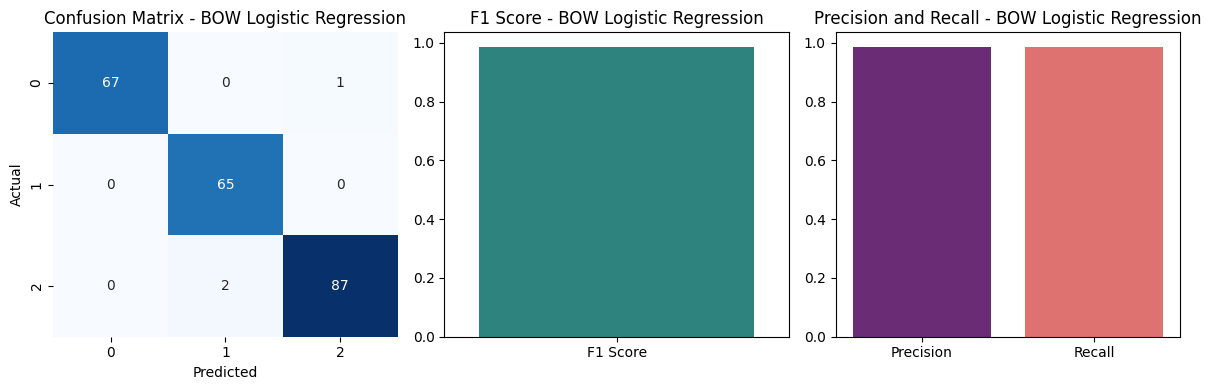

Results saved to /content/drive/MyDrive/work2/Final/evaluation_results.csv


In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/work2/Final/Text_Work/Files/sentences.csv')
df1 = pd.read_csv('/content/drive/MyDrive/work2/Final/Text_Work/Files/updated_transcriptions_with_senti (1).csv')
urdu_doc = pd.concat([df, df1], ignore_index=True).dropna()

# Function to remove unwanted characters
def removing_unwanted_data(text):
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = nltk.WordPunctTokenizer().tokenize(text)
    return text

# Apply preprocessing
urdu_doc['text_cleaned'] = urdu_doc['Sentence'].map(removing_unwanted_data)

# Custom tokenizer function
def custom_tokenizer(doc):
    return doc

# Load the saved vectorizer and model
vectorizer_path = '/content/drive/MyDrive/work2/Final/Text_Work/Text_Models_2_and_3/Text_model_2_bow_vectorizer.pkl'
model_path = '/content/drive/MyDrive/work2/Final/Text_Work/Text_Models_2_and_3/Text_model_2_logistic_regression_bow.pkl'

vectorizer = joblib.load(vectorizer_path)
model = joblib.load(model_path)

# Transform the data using the loaded vectorizer
X = vectorizer.transform(urdu_doc['text_cleaned'])
y = urdu_doc['Label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate the loaded model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print evaluation metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Visualize the results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - BOW Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 3, 2)
sns.barplot(x=['F1 Score'], y=[f1], palette="viridis")
plt.title("F1 Score - BOW Logistic Regression")

plt.subplot(1, 3, 3)
sns.barplot(x=['Precision', 'Recall'], y=[precision, recall], palette="magma")
plt.title("Precision and Recall - BOW Logistic Regression")

plt.tight_layout()
plt.show()

# Save results in a pandas DataFrame
results_df = pd.DataFrame({
    'Model Name': ['BOW Logistic Regression'],
    'Model Path': [model_path],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

# Path to the results file
results_file = '/content/drive/MyDrive/work2/Final/evaluation_results.csv'

# Check if the results file exists and handle the append operation correctly
if os.path.exists(results_file):
    # If it exists, read the existing data
    existing_df = pd.read_csv(results_file)
    # Append the new results
    updated_df = pd.concat([existing_df, results_df], ignore_index=True)
    updated_df.to_csv(results_file, index=False)
else:
    results_df.to_csv(results_file, index=False)

print(f"Results saved to {results_file}")


In [ ]:
import pandas as pd

# Read the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/work2/Final/evaluation_results.csv')

# Show the first 5 rows
results_df.head(10)


,Model Name,Model Path,Accuracy,Precision,Recall,F1 Score
0,Random Forest,/content/drive/MyDrive/work2/Final/Image_Model...,0.631285,0.636983,0.631285,0.630483
1,MobileNetV2,/content/drive/MyDrive/work2/Final/Image_Model...,0.653631,0.652923,0.653631,0.652066
2,LSTM,/content/drive/MyDrive/work2/Final//Audio_Mode...,0.521739,0.557971,0.521739,0.445201
3,Audio Sentiment RF,/content/drive/MyDrive/work2/Final/Audio_Model...,0.521739,0.557971,0.521739,0.445201
4,BERT Multilingual,/content/drive/MyDrive/work2/Final/Text_Work/T...,0.990991,0.991664,0.990792,0.991191
5,BOW Logistic Regression,/content/drive/MyDrive/work2/Final/Text_Work/T...,0.986486,0.986704,0.986486,0.986500
6,BOW Logistic Regression,/content/drive/MyDrive/work2/Final/Text_Work/T...,0.986486,0.986704,0.986486,0.986500


In [ ]:
import pandas as pd

# Read the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/work2/Final/evaluation_results.csv')

# Show the first 10 rows
print("Original DataFrame:")
print(results_df.head(10))

# Delete the last row
results_df = results_df[:-1]

# Save the updated DataFrame back to the CSV file
results_df.to_csv('/content/drive/MyDrive/work2/Final/evaluation_results.csv', index=False)

# Verify the last row has been deleted
print("Updated DataFrame:")
results_df.head(10)


Original DataFrame:
                Model Name                                         Model Path  \
0            Random Forest  /content/drive/MyDrive/work2/Final/Image_Model...   
1              MobileNetV2  /content/drive/MyDrive/work2/Final/Image_Model...   
2                     LSTM  /content/drive/MyDrive/work2/Final//Audio_Mode...   
3       Audio Sentiment RF  /content/drive/MyDrive/work2/Final/Audio_Model...   
4        BERT Multilingual  /content/drive/MyDrive/work2/Final/Text_Work/T...   
5  BOW Logistic Regression  /content/drive/MyDrive/work2/Final/Text_Work/T...   
6  BOW Logistic Regression  /content/drive/MyDrive/work2/Final/Text_Work/T...   

   Accuracy  Precision    Recall  F1 Score  
0  0.631285   0.636983  0.631285  0.630483  
1  0.653631   0.652923  0.653631  0.652066  
2  0.521739   0.557971  0.521739  0.445201  
3  0.521739   0.557971  0.521739  0.445201  
4  0.990991   0.991664  0.990792  0.991191  
5  0.986486   0.986704  0.986486  0.986500  
6  0.986486   0.

,Model Name,Model Path,Accuracy,Precision,Recall,F1 Score
0,Random Forest,/content/drive/MyDrive/work2/Final/Image_Model...,0.631285,0.636983,0.631285,0.630483
1,MobileNetV2,/content/drive/MyDrive/work2/Final/Image_Model...,0.653631,0.652923,0.653631,0.652066
2,LSTM,/content/drive/MyDrive/work2/Final//Audio_Mode...,0.521739,0.557971,0.521739,0.445201
3,Audio Sentiment RF,/content/drive/MyDrive/work2/Final/Audio_Model...,0.521739,0.557971,0.521739,0.445201
4,BERT Multilingual,/content/drive/MyDrive/work2/Final/Text_Work/T...,0.990991,0.991664,0.990792,0.991191
5,BOW Logistic Regression,/content/drive/MyDrive/work2/Final/Text_Work/T...,0.986486,0.986704,0.986486,0.986500


In [ ]:
import pandas as pd

# Read the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/work2/Final/evaluation_results.csv')

# Show the first 5 rows
results_df.head(10)

,Model Name,Model Path,Accuracy,Precision,Recall,F1 Score
0,Random Forest,/content/drive/MyDrive/work2/Final/Image_Model...,0.631285,0.636983,0.631285,0.630483
1,MobileNetV2,/content/drive/MyDrive/work2/Final/Image_Model...,0.653631,0.652923,0.653631,0.652066
2,LSTM,/content/drive/MyDrive/work2/Final//Audio_Mode...,0.521739,0.557971,0.521739,0.445201
3,Audio Sentiment RF,/content/drive/MyDrive/work2/Final/Audio_Model...,0.521739,0.557971,0.521739,0.445201
4,BERT Multilingual,/content/drive/MyDrive/work2/Final/Text_Work/T...,0.990991,0.991664,0.990792,0.991191
5,BOW Logistic Regression,/content/drive/MyDrive/work2/Final/Text_Work/T...,0.986486,0.986704,0.986486,0.986500
6,LSTM,/content/drive/MyDrive/work2/Final/Audio_Model...,0.529412,0.589154,0.529412,0.397359


In [ ]:

import pandas as pd
# Read the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/work2/Final/evaluation_results.csv')

results_df = results_df.drop(2)

# Save the updated DataFrame back to the CSV file
results_df.to_csv('/content/drive/MyDrive/work2/Final/evaluation_results.csv', index=False)

# Verify the second row has been deleted
print("Updated DataFrame:")
results_df.head(10)


Updated DataFrame:


,Model Name,Model Path,Accuracy,Precision,Recall,F1 Score
0,Random Forest,/content/drive/MyDrive/work2/Final/Image_Model...,0.631285,0.636983,0.631285,0.630483
1,MobileNetV2,/content/drive/MyDrive/work2/Final/Image_Model...,0.653631,0.652923,0.653631,0.652066
3,Audio Sentiment RF,/content/drive/MyDrive/work2/Final/Audio_Model...,0.521739,0.557971,0.521739,0.445201
4,BERT Multilingual,/content/drive/MyDrive/work2/Final/Text_Work/T...,0.990991,0.991664,0.990792,0.991191
5,BOW Logistic Regression,/content/drive/MyDrive/work2/Final/Text_Work/T...,0.986486,0.986704,0.986486,0.986500
6,LSTM,/content/drive/MyDrive/work2/Final/Audio_Model...,0.529412,0.589154,0.529412,0.397359


In [ ]:
import pandas as pd

# Read the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/work2/Final/evaluation_results.csv')

# Swap the 4th and 6th rows (index 3 and 5 since it's zero-indexed)
results_df.iloc[[3, 5]] = results_df.iloc[[5, 3]].values

# Save the updated DataFrame back to the CSV file
results_df.to_csv('/content/drive/MyDrive/work2/Final/evaluation_results.csv', index=False)

# Verify the rows have been swapped
print("Updated DataFrame:")
results_df.head(10)




Updated DataFrame:


,Model Name,Model Path,Accuracy,Precision,Recall,F1 Score
0,Random Forest,/content/drive/MyDrive/work2/Final/Image_Model...,0.631285,0.636983,0.631285,0.630483
1,MobileNetV2,/content/drive/MyDrive/work2/Final/Image_Model...,0.653631,0.652923,0.653631,0.652066
2,Audio Sentiment RF,/content/drive/MyDrive/work2/Final/Audio_Model...,0.521739,0.557971,0.521739,0.445201
3,LSTM,/content/drive/MyDrive/work2/Final/Audio_Model...,0.529412,0.589154,0.529412,0.397359
4,BOW Logistic Regression,/content/drive/MyDrive/work2/Final/Text_Work/T...,0.986486,0.986704,0.986486,0.986500
5,BERT Multilingual,/content/drive/MyDrive/work2/Final/Text_Work/T...,0.990991,0.991664,0.990792,0.991191


In [ ]:
import pandas as pd

# Read the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/work2/Final/evaluation_results.csv')

# Show the first 5 rows
results_df.head(10)

,Model Name,Model Path,Accuracy,Precision,Recall,F1 Score
0,Random Forest,/content/drive/MyDrive/work2/Final/Image_Model...,0.643123,0.644568,0.643123,0.643094
1,MobileNetV2,/content/drive/MyDrive/work2/Final/Image_Model...,0.653631,0.652923,0.653631,0.652066
2,LSTM,/content/drive/MyDrive/work2/Final/Old_audio_m...,0.529412,0.589154,0.529412,0.397359
3,Audio Sentiment RF,/content/drive/MyDrive/work2/Final/Audio_Model...,0.521739,0.557971,0.521739,0.445201
4,BERT Multilingual,/content/drive/MyDrive/work2/Final/Text_Work/T...,0.990991,0.991160,0.990868,0.990921
5,BOW Logistic Regression,/content/drive/MyDrive/work2/Final/Text_Work/T...,0.986486,0.986704,0.986486,0.986500
